

- Load data from: CSV path, local Kaggle download path, or sklearn toy datasets.
- Auto-detect task: Classification / Regression / Clustering (or user override).
- Interactive CONFIG block to enable/disable: sampling, normalization, standardization, dimensionality reduction, outlier removal, feature selection.
- Separate blocks for EDA, Visualizations, Preprocessing, Model Training (classification/regression/clustering), Model Evaluation, Predictions, and PDF report generation.
- Output: trained pipelines, metrics table, visualizations saved, and final PDF report.


In [61]:

# Standard imports
import os, sys, json, math, warnings, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8,5)
sns.set(style='whitegrid')


In [62]:

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,
                             mean_squared_error, r2_score, confusion_matrix, classification_report)

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans

try:
    from imblearn.over_sampling import SMOTE, RandomOverSampler
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except Exception as e:
    IMBLEARN_AVAILABLE = False

try:
    from fpdf import FPDF
    FPDF_AVAILABLE = True
except Exception as e:
    FPDF_AVAILABLE = False

# sklearn sample datasets
from sklearn.datasets import load_breast_cancer


In [76]:


CONFIG = {
    'csv_path': None, #custom input path
    'kaggle_local_path': None, #input path
    'sklearn_name': 'breast_cancer', #dataset name

    # Task selection - 'auto', 'classification', 'regression', 'clustering'
    'task': 'auto',

    # Train/test split
    'test_size': 0.25,
    'random_state': 42,

    # Preprocessing options (custom mode)
    'apply_sampling': False,
    'sampling_method': 'smote',

    'apply_normalization': False,
    'apply_standardization': True,

    'apply_dim_reduction': False,
    'dim_method': 'pca',
    'dim_components': 2,

    'apply_outlier_removal': False,
    'outlier_method': 'isolation_forest',

    'classification_models': {
        'LogisticRegression': LogisticRegression(max_iter=500),
        'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
        'SVC': SVC(probability=True)
    },
    'regression_models': {
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
        'SVR': SVR()
    },
    'clustering_models': {
        'KMeans': KMeans(n_clusters=2, random_state=42)
    },

    'report_path': 'ML_Report.pdf',

    'fig_dir': 'graph_images'
}

os.makedirs(CONFIG['fig_dir'], exist_ok=True)
print('CONFIG loaded. Figures will be saved to', CONFIG['fig_dir'])


CONFIG loaded. Figures will be saved to graph_images


In [77]:
pwd

'C:\\Syam\\Sept-15-PDEAI\\Machine Learning\\pipeLine'

In [78]:

def load_data_from_config(config):
    if config['csv_path']:
        print('Loading CSV from', config['csv_path'])
        df = pd.read_csv(config['csv_path'])
        return df
    if config['kaggle_local_path']:
        # try to read any csv file found in that folder
        print('Loading first CSV found under kaggle local path', config['kaggle_local_path'])
        files = [os.path.join(config['kaggle_local_path'], f) for f in os.listdir(config['kaggle_local_path']) if f.endswith('.csv')]
        if not files:
            raise FileNotFoundError('No CSV found under kaggle_local_path')
        df = pd.read_csv(files[0])
        return df
    if config['sklearn_name']:
        name = config['sklearn_name']
        if name == 'breast_cancer':
            data = load_breast_cancer(as_frame=True)
        elif name == 'boston':
            try:
                data = load_boston(as_frame=True)
            except:
                raise RuntimeError('boston dataset may be removed from sklearn; use another dataset')
        elif name == 'iris':
            data = load_iris(as_frame=True)
        else:
            raise ValueError('Unknown sklearn_name')
        df = data.frame.copy()
        # ensure target column exists as 'target' if classification/regression
        if 'target' not in df.columns:
            df['target'] = data.target
        return df
    raise ValueError('No data source provided in CONFIG')


In [79]:

def detect_task(df, config):
    if config['task'] != 'auto':
        return config['task']

    if 'target' in df.columns:
        y = df['target']
        if y.nunique() <= 10 and y.dtype in [np.int64, np.int32, np.int16, object] :

            return 'classification'
        else:
            return 'regression'

    return 'clustering'


In [80]:

def eda_summary(df, head=5):
    print('Shape:', df.shape)
    display(df.head(head))
    print('\nDtypes:\n', df.dtypes)
    print('\nMissing values:\n', df.isnull().sum().sort_values(ascending=False).head(20))
    print('\nDescribe:\n', df.describe().T)
    print('\nValue counts (top columns):')
    for c in df.select_dtypes(include=['object','category']).columns[:5]:
        print('\n', c, df[c].value_counts().head())

def plot_correlation(df, savepath=None):
    num = df.select_dtypes(include=[np.number])
    corr = num.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap='coolwarm', center=0)
    plt.title('Correlation matrix')
    if savepath: plt.savefig(savepath, bbox_inches='tight')
    plt.show()

def plot_target_distribution(df):
    if 'target' not in df.columns:
        print('No target column to plot.')
        return
    plt.figure(figsize=(6,4))
    sns.countplot(x='target', data=df)
    plt.title('Target distribution')
    plt.savefig(os.path.join(CONFIG['fig_dir'], 'target_distribution.png'), bbox_inches='tight')
    plt.show()

def plot_feature_distributions(df, n=6):
    num = df.select_dtypes(include=[np.number]).columns.tolist()
    sample = num[:n]
    df[sample].hist(figsize=(12,8), bins=20)
    plt.tight_layout()
    fpath = os.path.join(CONFIG['fig_dir'], 'feature_distributions.png')
    plt.savefig(fpath, bbox_inches='tight')
    plt.show()


In [81]:

from sklearn.ensemble import IsolationForest

def remove_outliers(X, y, config):
    if not config['apply_outlier_removal']:
        return X, y
    print('Removing outliers with IsolationForest...')
    iso = IsolationForest(contamination=0.03, random_state=config['random_state'])
    mask = iso.fit_predict(X) != -1
    print('Removed', np.sum(~mask), 'rows as outliers')
    return X.loc[mask, :], y.loc[mask]

def apply_sampling(X, y, config):
    if not config['apply_sampling']:
        return X, y
    if not IMBLEARN_AVAILABLE:
        raise RuntimeError('imblearn not installed but sampling requested')
    method = config['sampling_method']
    print('Applying sampling method ->', method)
    if method == 'smote':
        s = SMOTE(random_state=config['random_state'])
    elif method == 'random_over':
        s = RandomOverSampler(random_state=config['random_state'])
    elif method == 'random_under':
        s = RandomUnderSampler(random_state=config['random_state'])
    else:
        raise ValueError('Unknown sampling method')
    X_res, y_res = s.fit_resample(X, y)
    X_res = pd.DataFrame(X_res, columns=X.columns)
    y_res = pd.Series(y_res, name=y.name)
    print('Sampled shape:', X_res.shape)
    return X_res, y_res

def build_preprocessing_steps(config):
    steps = []
    steps.append(('imputer', SimpleImputer(strategy='mean')))
    if config['apply_normalization']:
        steps.append(('minmax', MinMaxScaler()))
    if config['apply_standardization']:
        steps.append(('std', StandardScaler()))
    if config['apply_dim_reduction'] and config['dim_method'] == 'pca':
        steps.append(('pca', PCA(n_components=config['dim_components'])))
    return steps


In [82]:

def build_pipeline_for_model(model, config):
    steps = build_preprocessing_steps(config)
    steps.append(('model', model))
    return Pipeline(steps)

def evaluate_classification(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = None
    try:
        y_proba = pipeline.predict_proba(X_test)[:,1]
    except:
        pass
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    return metrics, y_pred, y_proba

def evaluate_regression(pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    metrics = {
        'rmse': math.sqrt(mean_squared_error(y_test, y_pred)),
        'r2': r2_score(y_test, y_pred)
    }
    return metrics, y_pred

def evaluate_clustering(model, X):
    labels = model.fit_predict(X)
    # simple outputs - user can add silhouette score etc.
    return {'n_clusters_found': len(np.unique(labels))}, labels


In [83]:

def train_models(df, config):

    task = detect_task(df, config)
    print('Detected task ->', task)
    results = []
    fitted = {}

    if task in ['classification', 'regression']:
        if 'target' not in df.columns:
            raise ValueError('No target column found for supervised task')
        X = df.drop(columns=['target']).copy()
        y = df['target'].copy()

        X, y = remove_outliers(X, y, config)


        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                            test_size=config['test_size'],
                                                            random_state=config['random_state'])
        X_train, y_train = apply_sampling(X_train, y_train, config)

        models = config['classification_models'] if task=='classification' else config['regression_models']

        for name, model in models.items():
            print('\nTraining', name)
            pipe = build_pipeline_for_model(model, config)
            pipe.fit(X_train, y_train)
            if task == 'classification':
                metrics, y_pred, y_proba = evaluate_classification(pipe, X_test, y_test)
            else:
                metrics, y_pred = evaluate_regression(pipe, X_test, y_test)
            metrics['model'] = name
            results.append(metrics)
            fitted[name] = {'pipeline': pipe, 'y_pred': y_pred}

            if task == 'classification':
                cm = confusion_matrix(y_test, y_pred)
                plt.figure(); sns.heatmap(cm, annot=True, fmt='d'); plt.title(f'CM - {name}')
                fpath = os.path.join(config['fig_dir'], f'cm_{name}.png'); plt.savefig(fpath, bbox_inches='tight'); plt.close()
            else:
                plt.figure(); plt.scatter(y_test, y_pred); plt.xlabel('y_true'); plt.ylabel('y_pred'); plt.title(f'Residuals - {name}')
                fpath = os.path.join(config['fig_dir'], f'resid_{name}.png'); plt.savefig(fpath, bbox_inches='tight'); plt.close()

    else:
        X = df.copy()
        models = config['clustering_models']
        for name, model in models.items():
            print('\nRunning clustering with', name)
            metrics, labels = evaluate_clustering(model, X)
            metrics['model'] = name
            results.append(metrics)
            fitted[name] = {'model': model, 'labels': labels}
            # scatter with first two numeric features
            num = X.select_dtypes(include=[np.number]).iloc[:,:2]
            plt.figure(); plt.scatter(num.iloc[:,0], num.iloc[:,1], c=labels); plt.title(f'Clusters - {name}')
            fpath = os.path.join(config['fig_dir'], f'clusters_{name}.png'); plt.savefig(fpath, bbox_inches='tight'); plt.close()

    results_df = pd.DataFrame(results)
    return results_df, fitted, task


In [84]:

def predict_with_model(pipeline, input_df):
    return pipeline.predict(input_df), (pipeline.predict_proba(input_df)[:,1] if hasattr(pipeline, 'predict_proba') else None)


In [85]:

def generate_pdf_report(results_df, config, description='ML Report', extra_notes=None):
    fig_dir = config['fig_dir']
    report_path = config['report_path']
    print('Generating PDF report at', report_path)

    images = [os.path.join(fig_dir, f) for f in sorted(os.listdir(fig_dir)) if f.endswith('.png')]

    if FPDF_AVAILABLE:
        pdf = FPDF()
        pdf.set_auto_page_break(auto=True, margin=15)
        pdf.add_page()
        pdf.set_font('Arial', 'B', 16)
        pdf.cell(0, 10, description, ln=True)
        pdf.set_font('Arial', '', 12)
        pdf.ln(4)
        pdf.cell(0, 8, 'Results summary:', ln=True)
        pdf.ln(2)
        # add results table text
        pdf.set_font('Arial', '', 10)
        for i, row in results_df.fillna('').iterrows():
            line = ', '.join([f"{k}:{v}" for k,v in row.items()])
            pdf.multi_cell(0, 6, line)
        if extra_notes:
            pdf.ln(4)
            pdf.multi_cell(0,6,'Notes: '+extra_notes)
        for img in images:
            pdf.add_page()
            pdf.image(img, x=10, y=20, w=180)
        pdf.output(report_path)
    else:
        from matplotlib.backends.backend_pdf import PdfPages
        with PdfPages(report_path) as pdf:
            plt.figure(figsize=(8.5,11))
            plt.text(0.5, 0.95, description, ha='center', fontsize=16)
            plt.axis('off')
            pdf.savefig(); plt.close()

            fig, ax = plt.subplots(figsize=(8.5, 11))
            ax.axis('off')
            t = ax.table(cellText=results_df.fillna('').values, colLabels=results_df.columns, loc='center')
            t.auto_set_font_size(False); t.set_fontsize(8)
            pdf.savefig(); plt.close()
            for img in images:
                im = plt.imread(img)
                fig, ax = plt.subplots(figsize=(8.5,11))
                ax.imshow(im); ax.axis('off')
                pdf.savefig(); plt.close()
    print('Report saved to', report_path)
    return report_path



=== EDA ===
Shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0



Dtypes:
 mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symm

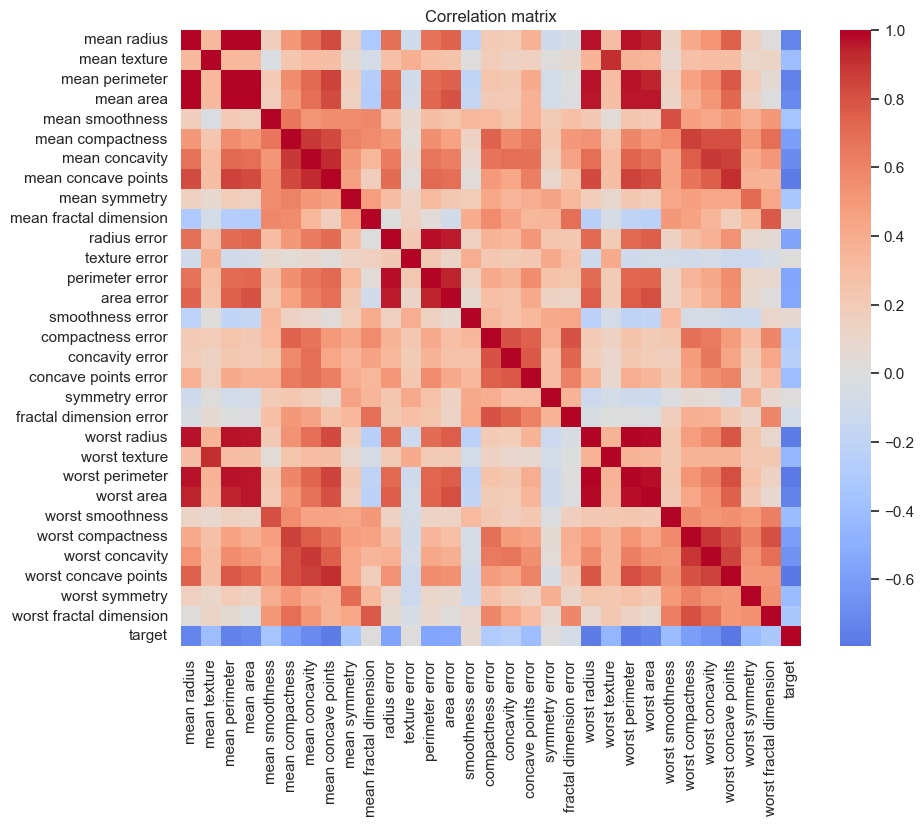

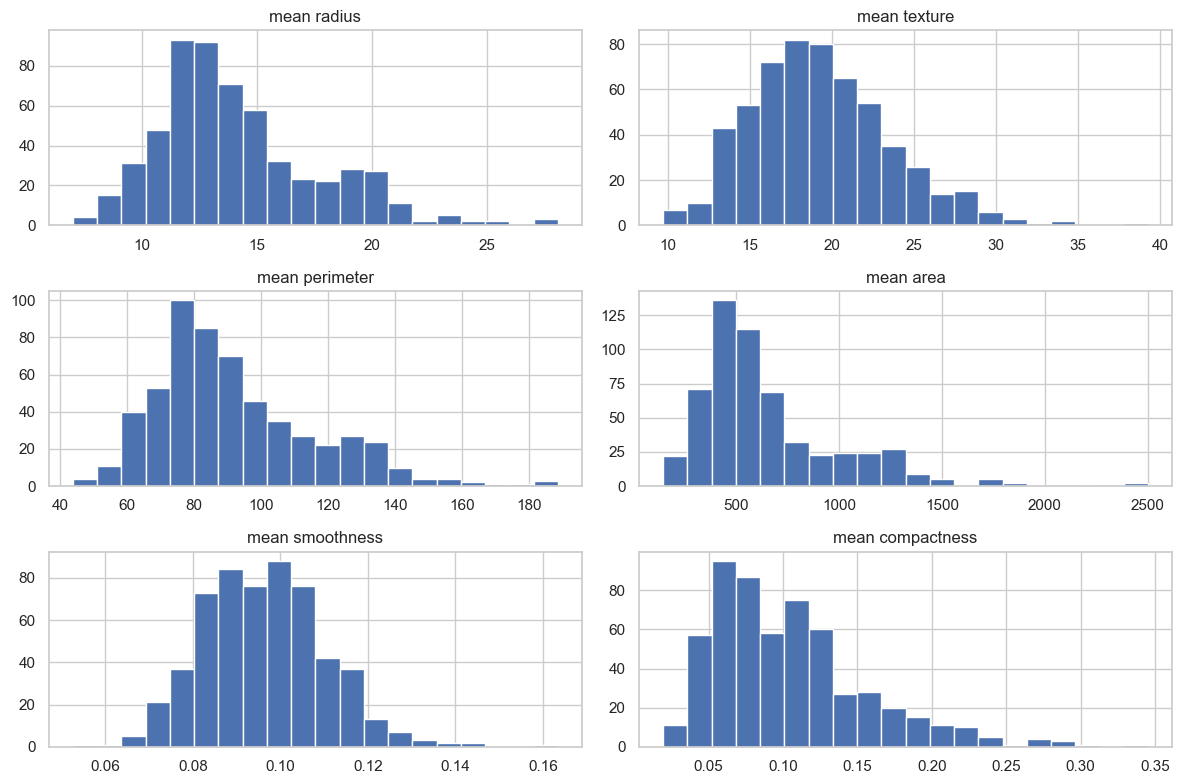

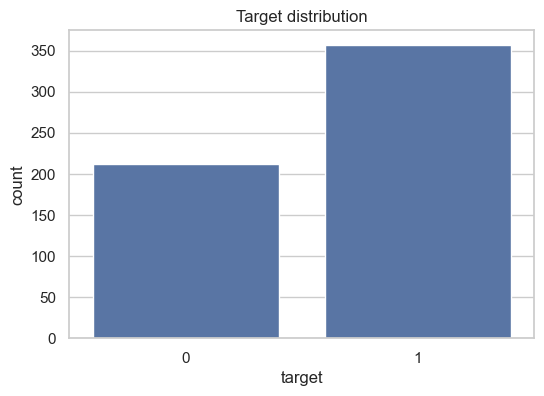


=== TRAIN / EVALUATE ===
Detected task -> classification

Training LogisticRegression

Training RandomForest

Training SVC

Results:


,accuracy,precision,recall,f1,model
0,0.979021,0.988636,0.977528,0.983051,LogisticRegression
1,0.965035,0.966667,0.977528,0.972067,RandomForest
2,0.972028,0.977528,0.977528,0.977528,SVC



=== Report ===
Generating PDF report at ML_Report.pdf
Report saved to ML_Report.pdf

Report generated: ML_Report.pdf


In [86]:


df = load_data_from_config(CONFIG)
print('\n=== EDA ===')
eda_summary(df)
plot_correlation(df)
plot_feature_distributions(df, n=6)
plot_target_distribution(df)

print('\n=== TRAIN / EVALUATE ===')
results_df, fitted_models, detected_task = train_models(df, CONFIG)
print('\nResults:')
display(results_df)

print('\n=== Report ===')
report_path = generate_pdf_report(results_df, CONFIG, description=f'ML Report - Task: {detected_task}')
print('\nReport generated:', report_path)


In [87]:

print('Prediction example usage shown in comments.')


Prediction example usage shown in comments.
